In [140]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(patchwork))

## 1. Import data and functions

In [55]:
data <- read.csv("table3.csv", header = T); 
data$vars <- factor(data$Treatment, levels = c("HFD", "HFD+LXN", "HFD+HXN", "HFD+TXN", "LFD")); head(data)

,ID,Treatment,Cal_cum,LV_TAG,lipidosis_area_pct,Fat_mass,subq_wt,epi_wat,mesenteric_wt,plasma_TAG,vars
,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,1,LFD,1425.870,367.77,17.596,11.152,0.40,1.80,0.33,38.547,LFD
2,2,LFD,1241.231,400.53,0.696,7.357,0.72,1.34,0.48,53.408,LFD
3,3,LFD,1298.180,379.47,17.311,10.517,0.89,2.08,0.94,68.087,LFD
4,4,LFD,1812.026,332.67,16.353,12.781,0.78,2.13,0.54,37.492,LFD
5,5,LFD,1373.638,408.33,5.164,6.385,0.26,0.97,0.32,46.053,LFD
6,6,LFD,1448.174,454.35,22.362,11.460,0.99,2.07,0.60,45.932,LFD


In [62]:
.ci <-
function(x,conf.level=0.95) {
  tri <- sort(na.omit(x))
  if (any(!is.finite(tri))) {tri <- tri[-which(!is.finite(tri))]}
  repet <- length(tri)
  int <- (1-conf.level)/2
  if(repet*int<1) {
    int.inf <- ceiling(repet*int)
  } else {
    int.inf <- floor(repet*int)
  }
  int.sup <- ceiling(repet*(1-int))
  result <- c("Inf"=tri[int.inf],"Sup"=tri[int.sup])
  return(result)
}

#ref: https://rdrr.io/cran/RVAideMemoire/src/R/ci.R

spearman.ci <-
function(var1,var2,nrep=1000,conf.level=0.95){
  if (length(var1)!=length(var2)) {stop(paste("'",deparse(substitute(var1)),"' and '",
    deparse(substitute(var2)),"' lengths differ",sep=""))}
  data.name <- paste(deparse(substitute(var1))," and ",deparse(substitute(var2)),"\n",nrep," replicates",sep="")
  nul <- as.numeric(row.names(table(c(which(is.na(var1)),which(is.na(var2))))))
  var1.2 <- if(length(nul)>0) {var1[-nul]} else {var1}
  var2.2 <- if(length(nul)>0) {var2[-nul]} else {var2}
  cor.fun <- function(data,ind) {
    as.numeric(suppressWarnings(cor.test(data[ind,1],data[ind,2],method="spearman")$estimate))
  }
  simul <- boot::boot(data.frame(var1.2,var2.2),cor.fun,R=nrep)
  interval <- .ci(simul$t,conf.level=conf.level)
  attr(interval,"conf.level") <- conf.level
  coeff <- as.numeric(suppressWarnings(cor.test(var1,var2,method="spearman")$estimate))
  names(coeff) <- "rho"
  result <- list(method="Spearman's rank correlation",conf.level=conf.level,rep=nrep,data.name=data.name,
    estimate=coeff,conf.int=interval)
  class(result) <- "htest"
  return(result)
}
#ref: https://rdrr.io/cran/RVAideMemoire/src/R/spearman.ci.R

## 2. Correlations

### 2.1 Spearman correlation between steatosis score and total caloric intake

In [65]:
data %>%
    group_by(vars) %>%
    summarise(r = spearman.ci(lipidosis_area_pct, Cal_cum)$estimate,
             pvalue = cor.test(lipidosis_area_pct, Cal_cum, method = "spearman")$p.value,
             lower = spearman.ci(lipidosis_area_pct, Cal_cum)$conf.int[1],
             upper = spearman.ci(lipidosis_area_pct, Cal_cum)$conf.int[2])

vars,r,pvalue,lower,upper
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
HFD,0.41258741,0.1844807,-0.2528302,0.8853047
HFD+LXN,0.37062937,0.2367322,-0.3138686,0.8714286
HFD+HXN,-0.01398601,0.9736939,-0.7090909,0.7184116
HFD+TXN,-0.06363636,0.8601035,-0.7302326,0.6000000
LFD,0.48951049,0.1096325,-0.1264368,0.8714286


### 2.2 Spearman correlation between liver TAG and total caloric intake

In [66]:
data %>%
    group_by(vars) %>%
    summarise(r = spearman.ci(LV_TAG, Cal_cum)$estimate,
             pvalue = cor.test(LV_TAG, Cal_cum, method = "spearman")$p.value,
             lower = spearman.ci(LV_TAG, Cal_cum)$conf.int[1],
             upper = spearman.ci(LV_TAG, Cal_cum)$conf.int[2])

vars,r,pvalue,lower,upper
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
HFD,0.01398601,0.973693904,-0.6441281,0.7173913
HFD+LXN,0.13286713,0.683365534,-0.5595668,0.6774194
HFD+HXN,0.50349650,0.098751570,-0.1970803,0.8376384
HFD+TXN,0.76363636,0.009215987,0.2995392,0.9718310
LFD,0.28671329,0.366408456,-0.3935018,0.8400000


### 2.3 Spearman correlation between total fat mass (by dexa) and total caloric intake

In [67]:
data %>%
    group_by(vars) %>%
    summarise(r = spearman.ci(Fat_mass, Cal_cum)$estimate,
             pvalue = cor.test(Fat_mass, Cal_cum, method = "spearman")$p.value,
             lower = spearman.ci(Fat_mass, Cal_cum)$conf.int[1],
             upper = spearman.ci(Fat_mass, Cal_cum)$conf.int[2])

vars,r,pvalue,lower,upper
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
HFD,-0.40559441,0.192612184,-0.8798587,0.3357143
HFD+LXN,-0.20279720,0.528100237,-0.9214286,0.5781818
HFD+HXN,0.09790210,0.766288456,-0.5555556,0.5913978
HFD+TXN,-0.02727273,0.945983670,-0.7383178,0.6074766
LFD,0.81818182,0.002027199,0.2671756,0.9786477


### 2.4 Spearman correlation between epididymal fat mass (by scale) and total caloric intake

In [73]:
data %>%
    group_by(vars) %>%
    summarise(r = spearman.ci(epi_wat, Cal_cum)$estimate,
             pvalue = cor.test(epi_wat, Cal_cum, method = "spearman")$p.value,
             lower = spearman.ci(epi_wat, Cal_cum)$conf.int[1],
             upper = spearman.ci(epi_wat, Cal_cum)$conf.int[2])

Warning message in cor.test.default(epi_wat, Cal_cum, method = "spearman"):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(epi_wat, Cal_cum, method = "spearman"):
“Cannot compute exact p-value with ties”


vars,r,pvalue,lower,upper
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
HFD,-0.2526331,0.42824449,-0.80791118,0.3741007
HFD+LXN,-0.5569185,0.05998361,-0.97785978,0.1560284
HFD+HXN,-0.5244755,0.08388459,-0.87142857,0.0459364
HFD+TXN,-0.4727273,0.14560623,-0.91588785,0.2710280
LFD,0.6433566,0.02795455,0.06521739,0.9424460


### 2.5 Spearman correlation between subq fat mass (by scale) and total caloric intake

In [76]:
data %>%
    group_by(vars) %>%
    summarise(r = spearman.ci(subq_wt, Cal_cum)$estimate,
             pvalue = cor.test(subq_wt, Cal_cum, method = "spearman")$p.value,
             lower = spearman.ci(subq_wt, Cal_cum)$conf.int[1],
             upper = spearman.ci(subq_wt, Cal_cum)$conf.int[2])

Warning message in cor.test.default(subq_wt, Cal_cum, method = "spearman"):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(subq_wt, Cal_cum, method = "spearman"):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(subq_wt, Cal_cum, method = "spearman"):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(subq_wt, Cal_cum, method = "spearman"):
“Cannot compute exact p-value with ties”


vars,r,pvalue,lower,upper
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
HFD,0.0000000,1.0000000,-0.5852868,0.6071429
HFD+LXN,0.3087738,0.3288039,-0.5106383,0.8108121
HFD+HXN,0.1681264,0.6014538,-0.5966942,0.6945455
HFD+TXN,-0.3090909,0.3560399,-0.7703349,0.3925234
LFD,0.3368442,0.2843262,-0.2319084,0.6058394


### 2.6 Spearman correlation between mesenteric fat mass (by scale) and total caloric intake

In [77]:
data %>%
    group_by(vars) %>%
    summarise(r = spearman.ci(mesenteric_wt, Cal_cum)$estimate,
             pvalue = cor.test(mesenteric_wt, Cal_cum, method = "spearman")$p.value,
             lower = spearman.ci(mesenteric_wt, Cal_cum)$conf.int[1],
             upper = spearman.ci(mesenteric_wt, Cal_cum)$conf.int[2])

Warning message in cor.test.default(mesenteric_wt, Cal_cum, method = "spearman"):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(mesenteric_wt, Cal_cum, method = "spearman"):
“Cannot compute exact p-value with ties”


vars,r,pvalue,lower,upper
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
HFD,-0.02797203,0.9386634,-0.7706093,0.6595745
HFD+LXN,-0.44055944,0.1542158,-0.9714286,0.2733813
HFD+HXN,0.32867133,0.2973851,-0.2971014,0.7941176
HFD+TXN,0.06833731,0.8417603,-0.6463718,0.6944444
LFD,0.21366057,0.5049127,-0.4643518,0.7513525


### 2.7 Spearman correlation between plasma TAG and total caloric intake

In [78]:
data %>%
    group_by(vars) %>%
    summarise(r = spearman.ci(plasma_TAG, Cal_cum)$estimate,
             pvalue = cor.test(plasma_TAG, Cal_cum, method = "spearman")$p.value,
             lower = spearman.ci(plasma_TAG, Cal_cum)$conf.int[1],
             upper = spearman.ci(plasma_TAG, Cal_cum)$conf.int[2])


## estimated coefficient +- qt(1-alpha/2, df) standard errors

vars,r,pvalue,lower,upper
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
HFD,0.1258741,0.69971222,-0.6075472,0.73722628
HFD+LXN,-0.4335664,0.16144643,-0.8798587,0.28467153
HFD+HXN,-0.2237762,0.48491114,-0.8260870,0.56428571
HFD+TXN,-0.6454545,0.03700105,-0.9700000,0.03846154
LFD,-0.6013986,0.04280687,-0.9000000,0.03272727


## 3. Linear regression

### 3.1 Linear regression between steatosis score and total caloric intake

In [113]:
df <- data %>%
    group_by(vars) %>%
    do(fit = lm(lipidosis_area_pct ~ Cal_cum, data = .)) %>%
    mutate(slope = summary(fit)$coefficients[2,1],
           err = summary(fit)$coefficients[2,2],
           CI.lower = (coef + c(-1,1)*err*qt(0.975, fit$df))[1],
           CI.upper = (coef + c(-1,1)*err*qt(0.975, fit$df))[2],
           r.squared = summary(fit)$r.squared,
           adj.r.squared = summary(fit)$adj.r.squared,
           p.value = summary(fit)$coefficients[2,4])
df[-2]

vars,slope,err,CI.lower,CI.upper,r.squared,adj.r.squared,p.value
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
HFD,0.038992289,0.017935565,-0.028712722,0.05121314,0.320945840,0.25304042,0.05479645
HFD+LXN,0.017305479,0.015899794,-0.024176742,0.04667716,0.105916217,0.01650784,0.30194969
HFD+HXN,0.010690598,0.027323656,-0.049630693,0.07213111,0.015077469,-0.08341478,0.70381359
HFD+TXN,0.002061449,0.009052097,-0.009227059,0.03172747,0.005729394,-0.10474512,0.82494431
LFD,0.031012601,0.012705398,-0.017059184,0.03955960,0.373354699,0.31069017,0.03479538


### 3.2 Linear regression between liver TAG and total caloric intake

In [112]:
df <- data %>%
    group_by(vars) %>%
    do(fit = lm(LV_TAG ~ Cal_cum, data = .)) %>%
    mutate(slope = summary(fit)$coefficients[2,1],
           err = summary(fit)$coefficients[2,2],
           CI.lower = (coef + c(-1,1)*err*qt(0.975, fit$df))[1],
           CI.upper = (coef + c(-1,1)*err*qt(0.975, fit$df))[2],
           r.squared = summary(fit)$r.squared,
           adj.r.squared = summary(fit)$adj.r.squared,
           p.value = summary(fit)$coefficients[2,4])
df[-2]

vars,slope,err,CI.lower,CI.upper,r.squared,adj.r.squared,p.value
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
HFD,-0.116226746,0.75009895,-1.6600744,1.6825748,0.0023951548,-0.09736533,0.87994473
HFD+LXN,0.080865205,0.22493878,-0.4899446,0.5124450,0.0127590363,-0.08596506,0.72669757
HFD+HXN,0.772553511,0.44482619,-0.9798843,1.0023847,0.2317333004,0.15490663,0.11307587
HFD+TXN,0.281986565,0.09164438,-0.1960638,0.2185642,0.5126630187,0.45851447,0.01320455
LFD,-0.006263476,0.17949327,-0.3886857,0.4111861,0.0001217535,-0.09986607,0.97284993


### 3.3 Linear regression between plasma TAG and total caloric intake

In [114]:
df <- data %>%
    group_by(vars) %>%
    do(fit = lm(plasma_TAG ~ Cal_cum, data = .)) %>%
    mutate(slope = summary(fit)$coefficients[2,1],
           err = summary(fit)$coefficients[2,2],
           CI.lower = (coef + c(-1,1)*err*qt(0.975, fit$df))[1],
           CI.upper = (coef + c(-1,1)*err*qt(0.975, fit$df))[2],
           r.squared = summary(fit)$r.squared,
           adj.r.squared = summary(fit)$adj.r.squared,
           p.value = summary(fit)$coefficients[2,4])
df[-2]

vars,slope,err,CI.lower,CI.upper,r.squared,adj.r.squared,p.value
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
HFD,0.02271031,0.02953836,-0.05456535,0.07706577,0.05581253,-0.03860622,0.45976040
HFD+LXN,-0.03357288,0.01851034,-0.02999340,0.05249382,0.24753420,0.17228762,0.09979209
HFD+HXN,-0.01606718,0.04167327,-0.08160362,0.10410403,0.01464724,-0.08388803,0.70790360
HFD+TXN,-0.02444727,0.01258171,-0.01721160,0.03971202,0.29552978,0.21725531,0.08389369
LFD,-0.02277021,0.01314955,-0.01804881,0.04054922,0.23068387,0.15375226,0.11401399


### 3.4 Linear regression between total fat mass and total caloric intake

In [115]:
df <- data %>%
    group_by(vars) %>%
    do(fit = lm(Fat_mass ~ Cal_cum, data = .)) %>%
    mutate(slope = summary(fit)$coefficients[2,1],
           err = summary(fit)$coefficients[2,2],
           CI.lower = (coef + c(-1,1)*err*qt(0.975, fit$df))[1],
           CI.upper = (coef + c(-1,1)*err*qt(0.975, fit$df))[2],
           r.squared = summary(fit)$r.squared,
           adj.r.squared = summary(fit)$adj.r.squared,
           p.value = summary(fit)$coefficients[2,4])
df[-2]

vars,slope,err,CI.lower,CI.upper,r.squared,adj.r.squared,p.value
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
HFD,-0.006027265,0.004455171,1.323467e-03,0.02117695,0.15470976,0.07018074,0.205891479
HFD+LXN,0.004430467,0.006170782,-2.499153e-03,0.02499957,0.04902178,-0.04607604,0.489206435
HFD+HXN,0.002373123,0.008940987,-8.671554e-03,0.03117197,0.00699553,-0.09230492,0.796076756
HFD+TXN,-0.001944626,0.004956918,3.687945e-05,0.02246353,0.01681289,-0.09243012,0.703961099
LFD,0.009689779,0.002402709,5.896639e-03,0.01660377,0.61924972,0.58117469,0.002388507


### 3.5 Linear regression between epididymal fat and total caloric intake

In [116]:
df <- data %>%
    group_by(vars) %>%
    do(fit = lm(epi_wat ~ Cal_cum, data = .)) %>%
    mutate(slope = summary(fit)$coefficients[2,1],
           err = summary(fit)$coefficients[2,2],
           CI.lower = (coef + c(-1,1)*err*qt(0.975, fit$df))[1],
           CI.upper = (coef + c(-1,1)*err*qt(0.975, fit$df))[2],
           r.squared = summary(fit)$r.squared,
           adj.r.squared = summary(fit)$adj.r.squared,
           p.value = summary(fit)$coefficients[2,4])
df[-2]

vars,slope,err,CI.lower,CI.upper,r.squared,adj.r.squared,p.value
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
HFD,-0.001864942,0.0023039045,0.006116788,0.01638363,0.06149477,-0.03235575,0.437081674
HFD+LXN,-0.001939055,0.0008633770,0.009326483,0.01317393,0.33528541,0.26881395,0.048516391
HFD+HXN,-0.003185989,0.0016352564,0.007606629,0.01489378,0.27514795,0.20266275,0.079971847
HFD+TXN,-0.001539081,0.0004426496,0.010248864,0.01225155,0.57324420,0.52582689,0.006971722
LFD,0.001339460,0.0005791873,0.009959697,0.01254072,0.34846508,0.28331159,0.043311192


### 3.6 Linear regression between subQ and total caloric intake

In [117]:
df <- data %>%
    group_by(vars) %>%
    do(fit = lm(subq_wt ~ Cal_cum, data = .)) %>%
    mutate(slope = summary(fit)$coefficients[2,1],
           err = summary(fit)$coefficients[2,2],
           CI.lower = (coef + c(-1,1)*err*qt(0.975, fit$df))[1],
           CI.upper = (coef + c(-1,1)*err*qt(0.975, fit$df))[2],
           r.squared = summary(fit)$r.squared,
           adj.r.squared = summary(fit)$adj.r.squared,
           p.value = summary(fit)$coefficients[2,4])
df[-2]

vars,slope,err,CI.lower,CI.upper,r.squared,adj.r.squared,p.value
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
HFD,-0.0002678418,0.0015556196,0.007784070,0.01471634,0.002955728,-0.09674870,0.8667331
HFD+LXN,0.0020398611,0.0009741241,0.009079723,0.01342069,0.304832914,0.23531621,0.0627014
HFD+HXN,0.0008441713,0.0015149895,0.007874600,0.01462581,0.030113609,-0.06687503,0.5896355
HFD+TXN,-0.0010042506,0.0007724329,0.009502842,0.01299757,0.158114942,0.06457216,0.2258691
LFD,0.0003427162,0.0003819516,0.010399166,0.01210125,0.074511571,-0.01803727,0.3906619


### 3.7 Linear regression between mesenteric fat and total caloric intake

In [118]:
df <- data %>%
    group_by(vars) %>%
    do(fit = lm(mesenteric_wt ~ Cal_cum, data = .)) %>%
    mutate(slope = summary(fit)$coefficients[2,1],
           err = summary(fit)$coefficients[2,2],
           CI.lower = (coef + c(-1,1)*err*qt(0.975, fit$df))[1],
           CI.upper = (coef + c(-1,1)*err*qt(0.975, fit$df))[2],
           r.squared = summary(fit)$r.squared,
           adj.r.squared = summary(fit)$adj.r.squared,
           p.value = summary(fit)$coefficients[2,4])
df[-2]

vars,slope,err,CI.lower,CI.upper,r.squared,adj.r.squared,p.value
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
HFD,-2.358721e-04,0.0009036002,0.009236860,0.01326355,6.767857e-03,-0.092555358,0.7993619
HFD+LXN,1.223506e-05,0.0007936604,0.009481821,0.01301859,2.376469e-05,-0.099973859,0.9880035
HFD+HXN,1.726105e-03,0.0016635131,0.007543669,0.01495674,9.720151e-02,0.006921659,0.3238830
HFD+TXN,-9.021581e-05,0.0006224330,0.009842165,0.01265825,2.328762e-03,-0.108523598,0.8879517
LFD,1.176511e-04,0.0003094008,0.010560819,0.01193959,1.425328e-02,-0.084321391,0.7117082


## Plots

In [165]:
ggplotRegression <- function (fit) {

require(ggplot2)

ggplot(fit$model, aes_string(x = names(fit$model)[2], y = names(fit$model)[1])) + 
  geom_point() +
  stat_smooth(method = "lm", col = "red", geom = "smooth") +
  labs(title = paste("Adj R2 = ",signif(summary(fit)$adj.r.squared, 5),
                     "Intercept =",signif(fit$coef[[1]],5 ),
                     " Slope =",signif(fit$coef[[2]], 5),
                     " P =",signif(summary(fit)$coef[2,4], 4)))
}

#https://sejohnston.com/2012/08/09/a-quick-and-easy-function-to-plot-lm-results-in-r/

theme_set(theme_bw())

In [185]:
options(repr.plot.width = 30, repr.plot.height = 10, repr.plot.res = 150)

In [128]:
txn <- data %>% filter(vars == "HFD+TXN"); hfd <- data %>% filter(vars == "HFD");
lxn <- data %>% filter(vars == "HFD+LXN"); hxn <- data %>% filter(vars == "HFD+HXN");
lfd <- data %>% filter(vars == "LFD")

In [151]:
txn_epi <- ggplotRegression(lm(epi_wat ~ Cal_cum, data = txn))
txn_fat <- ggplotRegression(lm(Fat_mass ~ Cal_cum, data = txn))
txn_subq <- ggplotRegression(lm(subq_wt ~ Cal_cum, data = txn))
txn_mes <- ggplotRegression(lm(mesenteric_wt ~ Cal_cum, data = txn))
txn_pla_tag <- ggplotRegression(lm(plasma_TAG ~ Cal_cum, data = txn))
txn_lv_tag <- ggplotRegression(lm(LV_TAG ~ Cal_cum, data = txn))
txn_steatosis <- ggplotRegression(lm(lipidosis_area_pct ~ Cal_cum, data = txn))

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



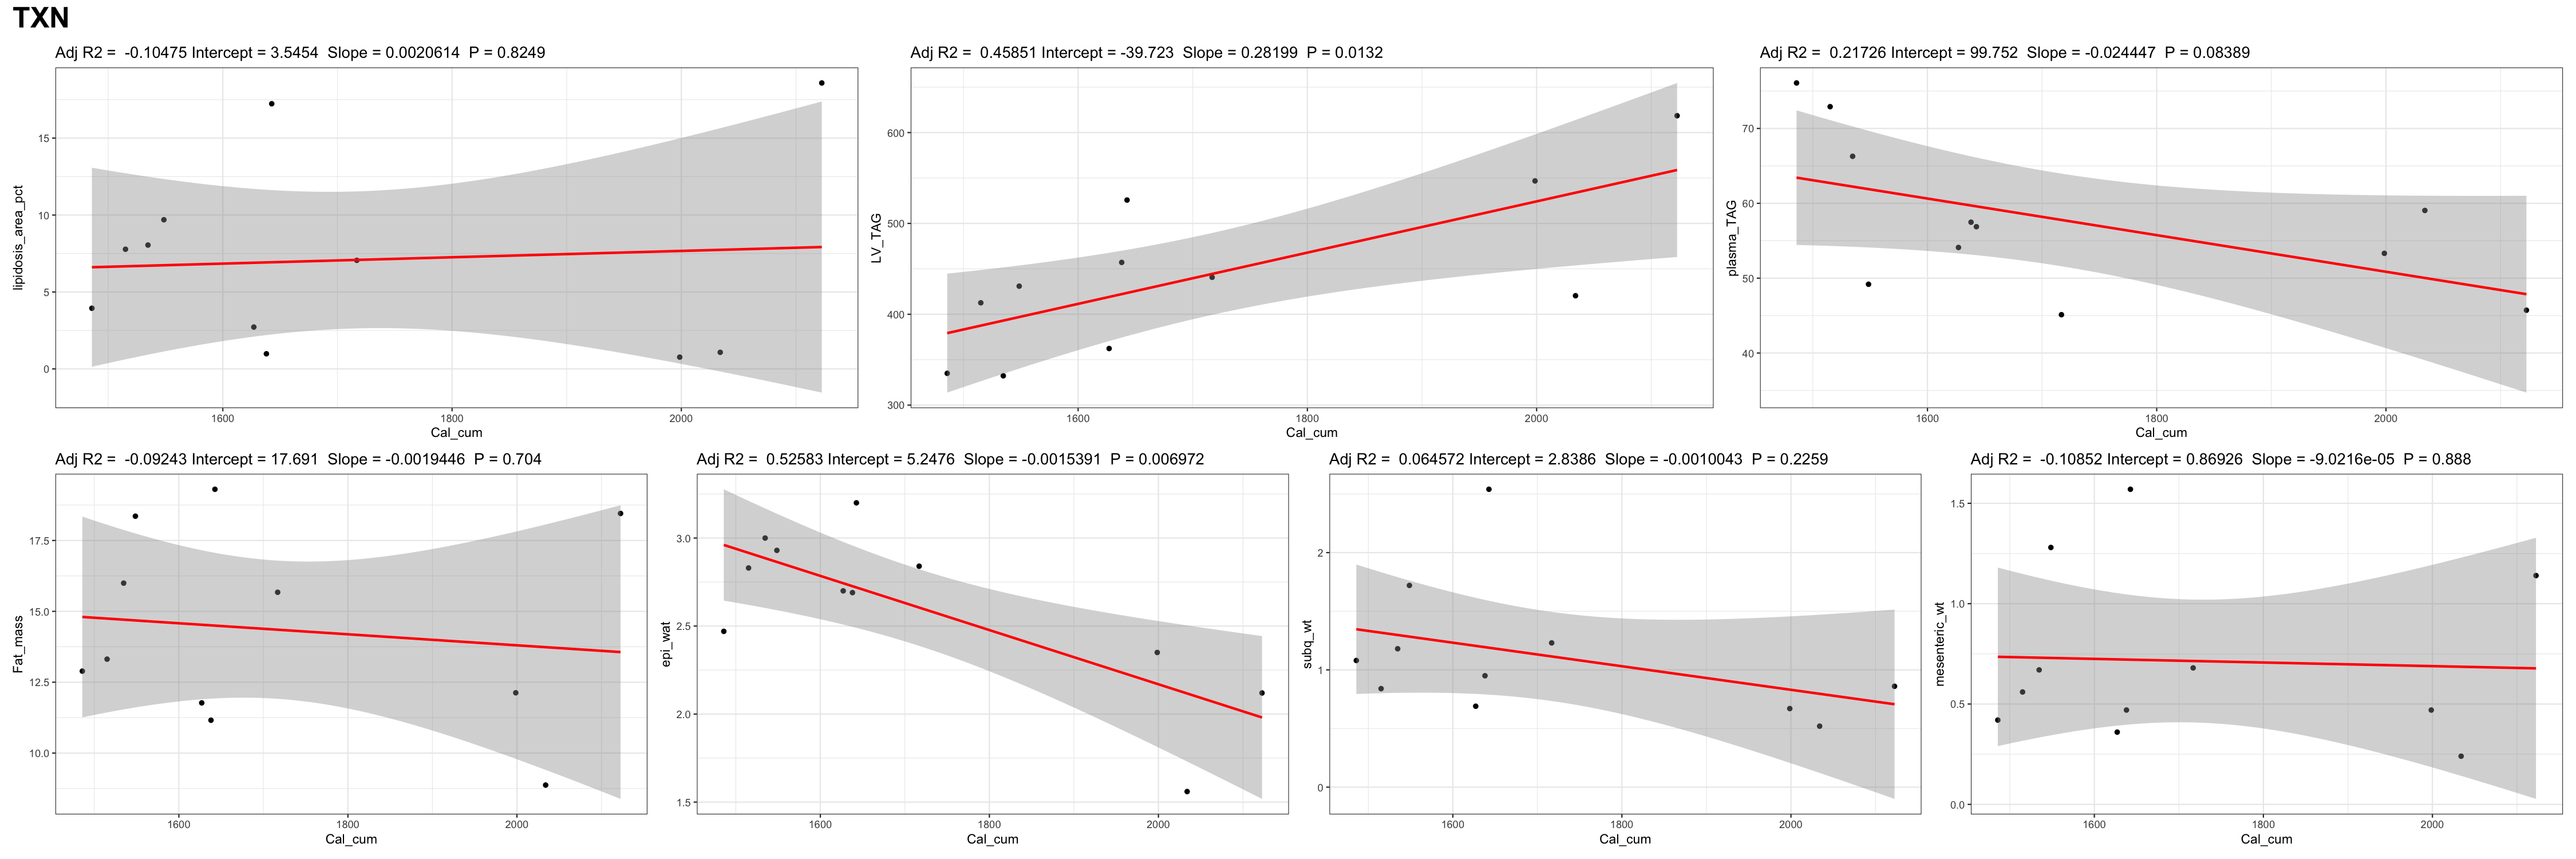

In [186]:
(txn_steatosis | txn_lv_tag | txn_pla_tag) / (txn_fat | txn_epi | txn_subq | txn_mes) + 
plot_annotation(title = 'TXN', 
                theme = theme(title = element_text(size = 20, face = 2)))

In [154]:
hfd_epi <- ggplotRegression(lm(epi_wat ~ Cal_cum, data = hfd))
hfd_fat <- ggplotRegression(lm(Fat_mass ~ Cal_cum, data = hfd))
hfd_subq <- ggplotRegression(lm(subq_wt ~ Cal_cum, data = hfd))
hfd_mes <- ggplotRegression(lm(mesenteric_wt ~ Cal_cum, data = hfd))
hfd_pla_tag <- ggplotRegression(lm(plasma_TAG ~ Cal_cum, data = hfd))
hfd_lv_tag <- ggplotRegression(lm(LV_TAG ~ Cal_cum, data = hfd))
hfd_steatosis <- ggplotRegression(lm(lipidosis_area_pct ~ Cal_cum, data = hfd))

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



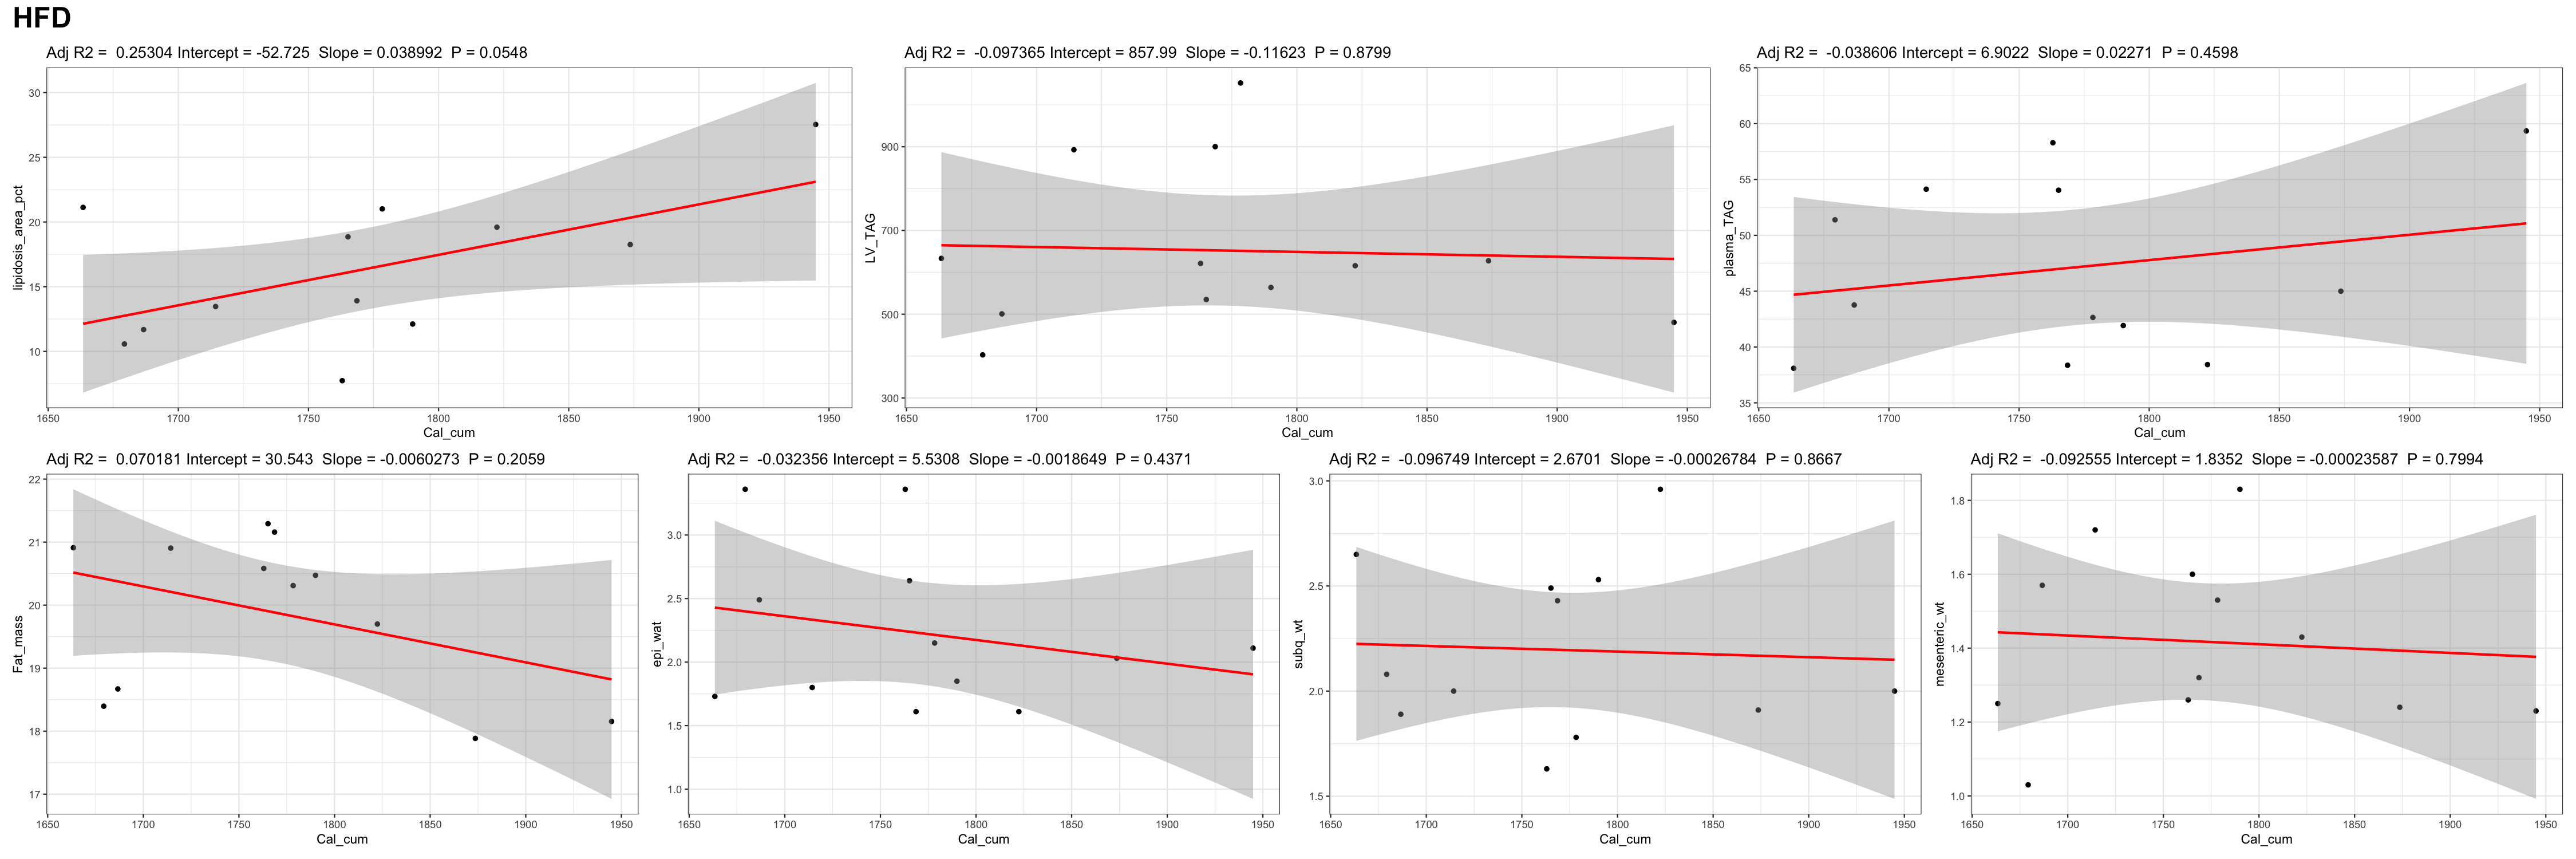

In [187]:
(hfd_steatosis | hfd_lv_tag | hfd_pla_tag) / (hfd_fat | hfd_epi | hfd_subq | hfd_mes)+ 
plot_annotation(title = 'HFD', 
                theme = theme(title = element_text(size = 20, face = 2)))

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



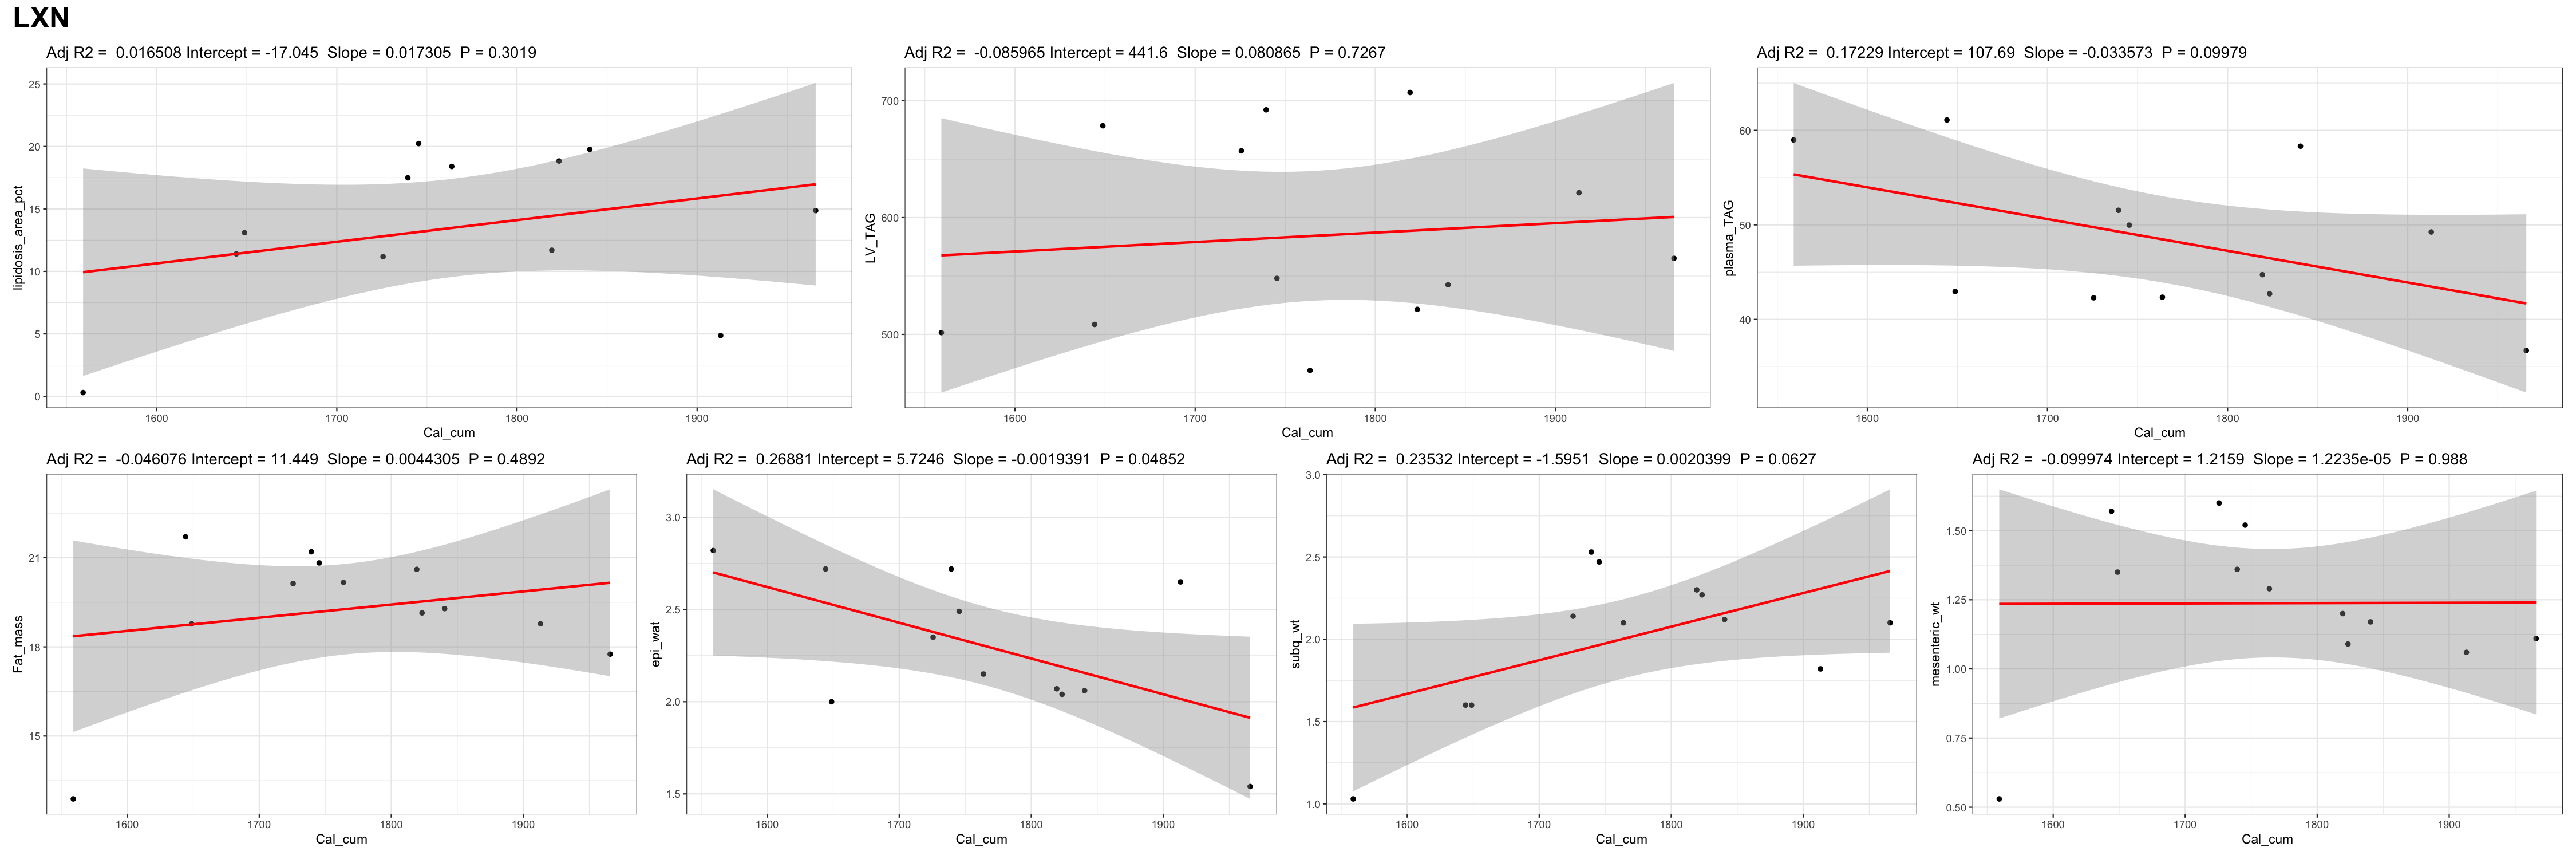

In [189]:
lxn_epi <- ggplotRegression(lm(epi_wat ~ Cal_cum, data = lxn))
lxn_fat <- ggplotRegression(lm(Fat_mass ~ Cal_cum, data = lxn))
lxn_subq <- ggplotRegression(lm(subq_wt ~ Cal_cum, data = lxn))
lxn_mes <- ggplotRegression(lm(mesenteric_wt ~ Cal_cum, data = lxn))
lxn_pla_tag <- ggplotRegression(lm(plasma_TAG ~ Cal_cum, data = lxn))
lxn_lv_tag <- ggplotRegression(lm(LV_TAG ~ Cal_cum, data = lxn))
lxn_steatosis <- ggplotRegression(lm(lipidosis_area_pct ~ Cal_cum, data = lxn))

(lxn_steatosis | lxn_lv_tag | lxn_pla_tag) / (lxn_fat | lxn_epi | lxn_subq | lxn_mes)+ 
plot_annotation(title = 'LXN', 
                theme = theme(title = element_text(size = 20, face = 2)))

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



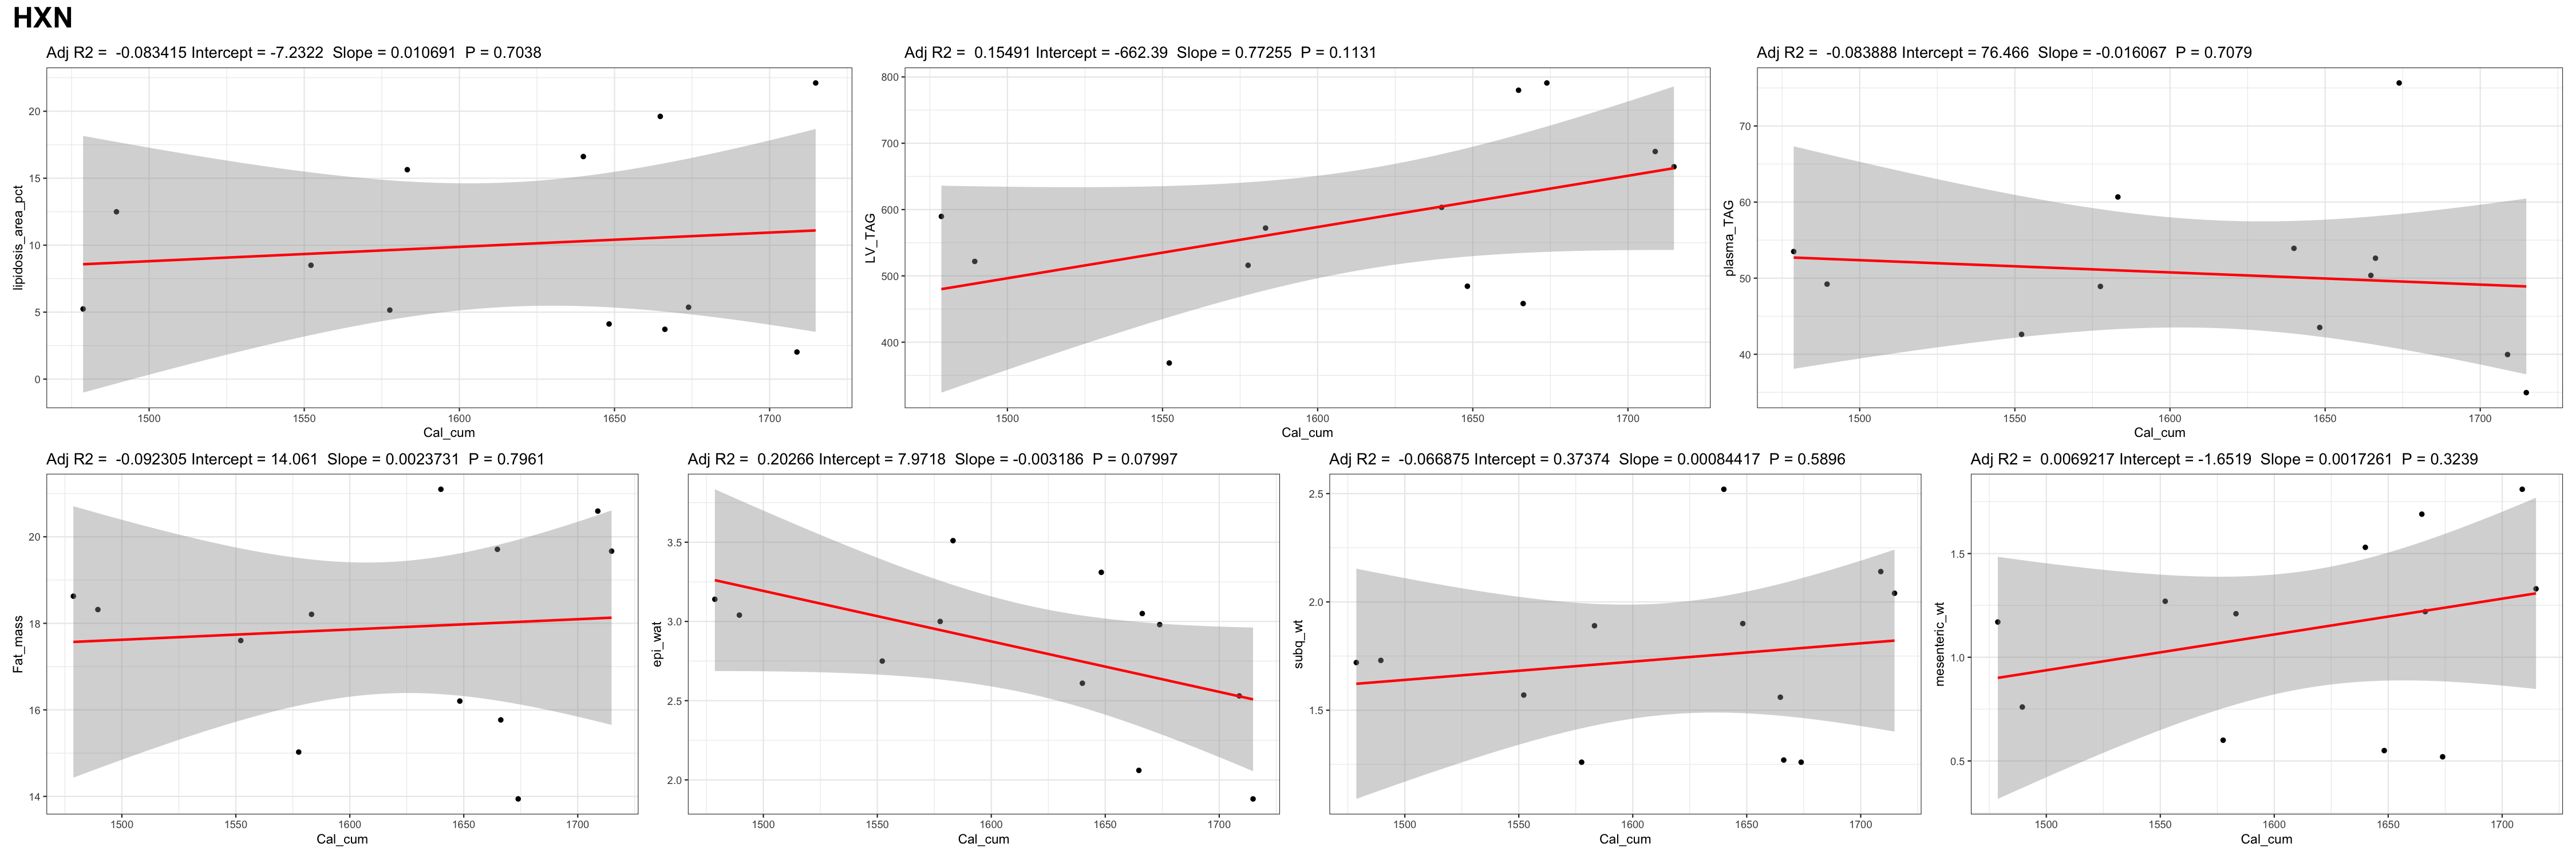

In [190]:
hxn_epi <- ggplotRegression(lm(epi_wat ~ Cal_cum, data = hxn))
hxn_fat <- ggplotRegression(lm(Fat_mass ~ Cal_cum, data = hxn))
hxn_subq <- ggplotRegression(lm(subq_wt ~ Cal_cum, data = hxn))
hxn_mes <- ggplotRegression(lm(mesenteric_wt ~ Cal_cum, data = hxn))
hxn_pla_tag <- ggplotRegression(lm(plasma_TAG ~ Cal_cum, data = hxn))
hxn_lv_tag <- ggplotRegression(lm(LV_TAG ~ Cal_cum, data = hxn))
hxn_steatosis <- ggplotRegression(lm(lipidosis_area_pct ~ Cal_cum, data = hxn))

(hxn_steatosis | hxn_lv_tag | hxn_pla_tag) / (hxn_fat | hxn_epi | hxn_subq | hxn_mes)+ 
plot_annotation(title = 'HXN', 
                theme = theme(title = element_text(size = 20, face = 2)))

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



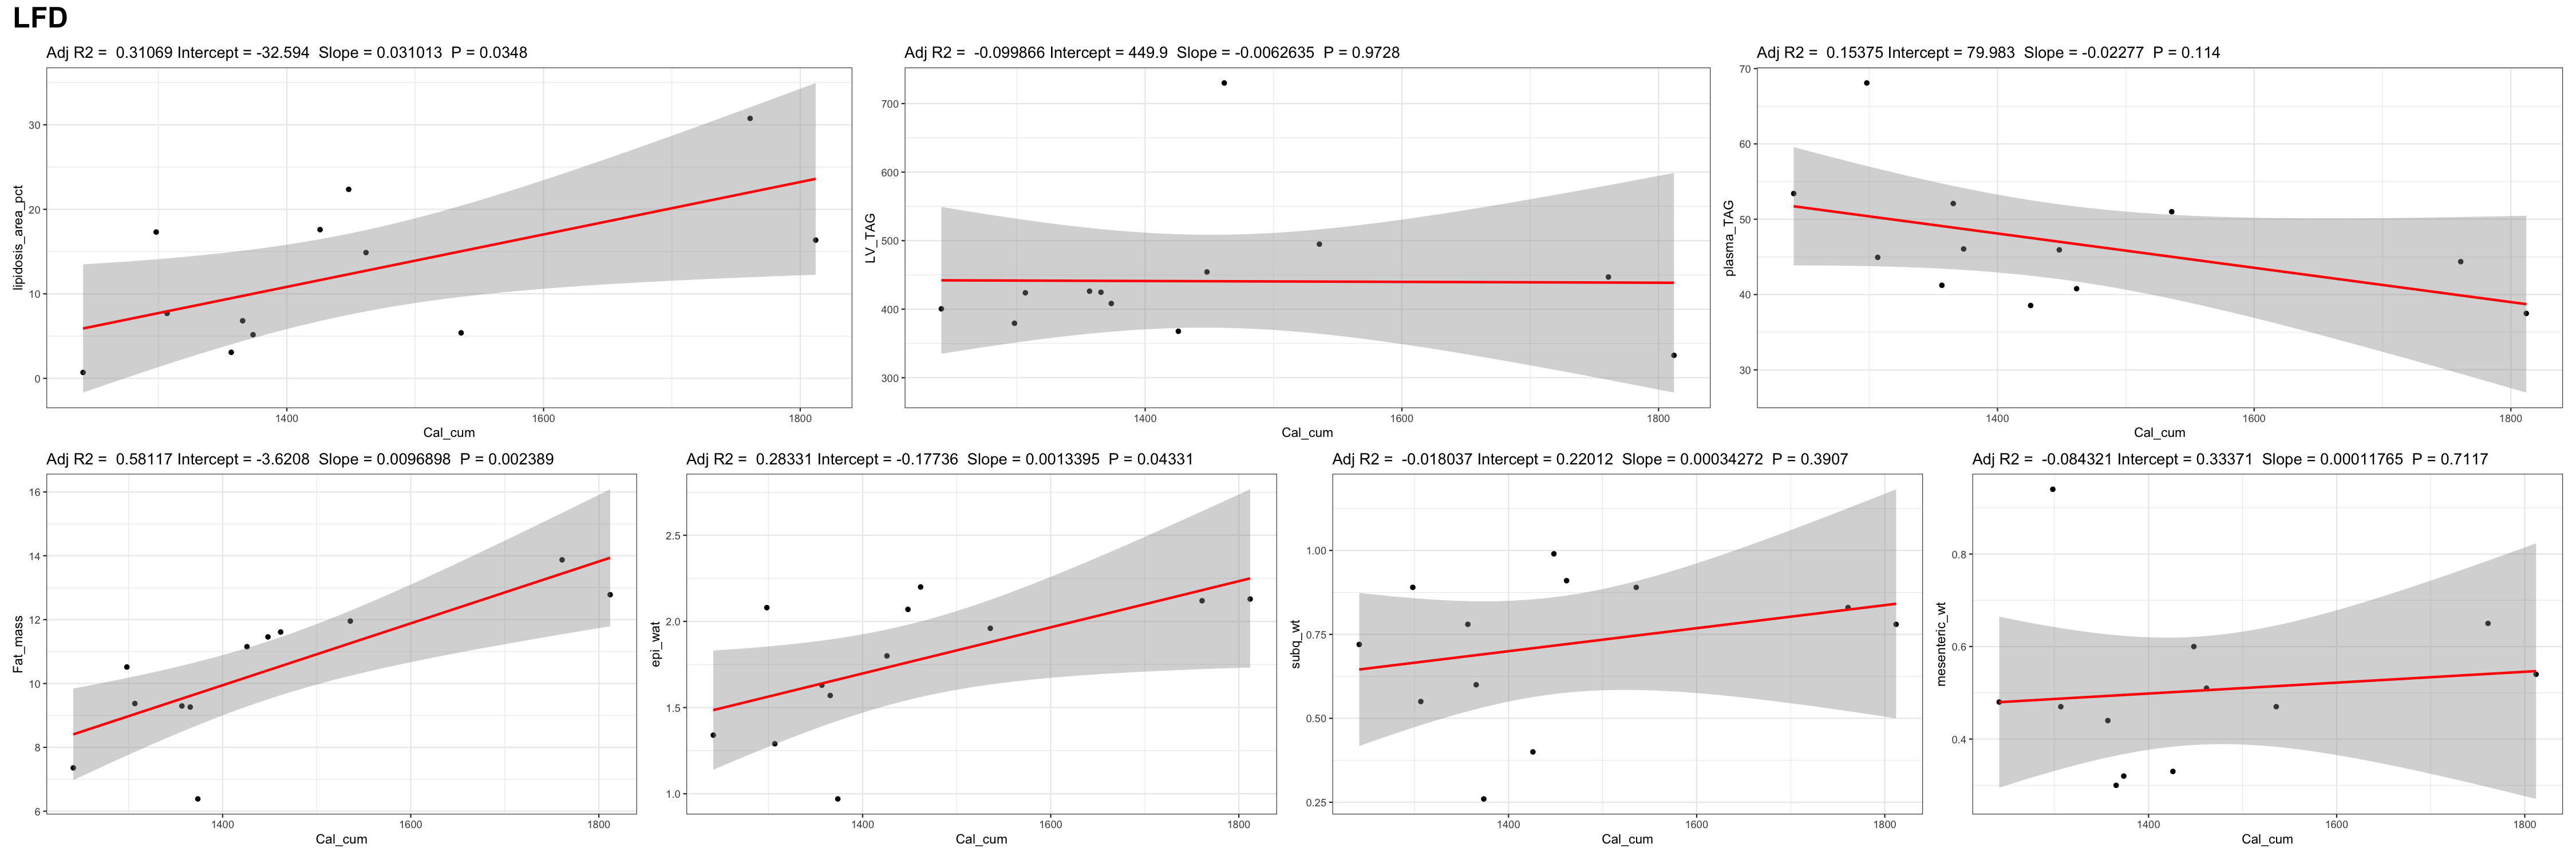

In [188]:
lfd_epi <- ggplotRegression(lm(epi_wat ~ Cal_cum, data = lfd))
lfd_fat <- ggplotRegression(lm(Fat_mass ~ Cal_cum, data = lfd))
lfd_subq <- ggplotRegression(lm(subq_wt ~ Cal_cum, data = lfd))
lfd_mes <- ggplotRegression(lm(mesenteric_wt ~ Cal_cum, data = lfd))
lfd_pla_tag <- ggplotRegression(lm(plasma_TAG ~ Cal_cum, data = lfd))
lfd_lv_tag <- ggplotRegression(lm(LV_TAG ~ Cal_cum, data = lfd))
lfd_steatosis <- ggplotRegression(lm(lipidosis_area_pct ~ Cal_cum, data = lfd))

(lfd_steatosis | lfd_lv_tag | lfd_pla_tag) / (lfd_fat | lfd_epi | lfd_subq | lfd_mes)+ 
plot_annotation(title = 'LFD', 
                theme = theme(title = element_text(size = 20, face = 2)))